In [1]:
%matplotlib ipympl

from pyresample import geometry, kd_tree
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
import glob
import sys
import os
import re

import ls2d
import microhhpy.constants as constants
from microhhpy.constants import xm_cams

In [2]:
Na = 6.022e23           # moluecules / mol
Mair = 29.96 / 1000.    # kg / mol !!

In [3]:
"""
Domain information from case setup.
"""
sys.path.append('/home/stratum2/meteo/models/LS2D_microhh_cases/corso/vinh_tan')
from global_settings import outer_dom, inner_dom, ls2d_settings, cams_eac4_variables, vgrid

In [36]:
"""
Data paths.
"""
data_path_raw = '/gpfs/work2/0/nwo21036/bart/corso/gems_data/vinh_tan/raw'            # GEMS observations.
data_path_amf = '/gpfs/work2/0/nwo21036/bart/corso/gems_data/vinh_tan/amf_corrected'  # GEMS observations.
sim_path = '/gpfs/work2/0/nwo21036/bart/corso/vinh_tan/'                              # Simulation.

In [37]:
"""
MicroHH data.
"""
def open_dataset(nc_file, domain, req_time=None):
    """
    Open Dataset, add datetime units, and optionally select a single time frame.
    """
    ds = xr.open_dataset(nc_file, decode_times=False)

    # From seconds since .. to date.
    ds = ds.assign_coords(time=pd.to_datetime(domain.start_date) + pd.to_timedelta(ds.time, unit="s"))

    if req_time is not None:
        ds = ds.sel(time=req_time, method='nearest')

    return ds

In [5]:
"""
CAMS data, LES domaim is only a few kms high..
"""
ls2d_settings['start_date'] = outer_dom.start_date
ls2d_settings['end_date'] = outer_dom.end_date

cams = ls2d.Read_cams(ls2d_settings, cams_eac4_variables)

def calc_grid(zstart, zend, ktot):

    zh = np.linspace(zstart, zend+0.1, ktot+1)
    dz = zh[1:] - zh[:-1]
    z = 0.5 * (zh[1:] + zh[:-1])

    return z, dz

# Calculate vertical integral from top-of-domain to 20 km (=troposphere (?) minus LES) and 20 to 70 km (stratosphere (?)).
z_tropo, dz_tropo = calc_grid(vgrid.zsize, 20_000, 64)
z_strato, dz_strato = calc_grid(20_000, 70_000, 63)

cams_tropo  = cams.get_les_input(z_tropo, n_av=2)
cams_strato = cams.get_les_input(z_strato, n_av=2)

Reading CAMS from 2021-03-03 12:00:00 to 2021-03-06 00:00:00 [17-09: 15:09]
 - Using nearest lat/lon = 11.32/108.81 (requested = 11.32/108.81), distance ~= 0.0 km
 - Averaging CAMS over a 1.25°×1.25° spatial area.
 - Using nearest lat/lon = 11.32/108.81 (requested = 11.32/108.81), distance ~= 0.0 km
 - Averaging CAMS over a 1.25°×1.25° spatial area.


In [38]:
# Calculate paths over troposphere only.
rho_tropo = cams_tropo.p / (constants.Rd * cams_tropo.t)

no2_vmr = cams_tropo.no2 * xm_cams['air'] / xm_cams['no2']
no_vmr  = cams_tropo.no  * xm_cams['air'] / xm_cams['no']
o3_vmr  = cams_tropo.go3 * xm_cams['air'] / xm_cams['o3']

no2_bg_path = np.sum(no2_vmr * rho_tropo * dz_tropo, axis=1)
no_bg_path  = np.sum(no_vmr  * rho_tropo * dz_tropo, axis=1)
o3_bg_path  = np.sum(o3_vmr  * rho_tropo * dz_tropo, axis=1)

In [39]:
"""
GEMS observations.
"""
def get_gems_nc_file(data_path, req_time):
    """
    Find NetCDF file corresponding to requested `req_time`.
    """
    dirs = list(os.listdir(data_path))
    dirs.sort()

    for d in dirs:
        nc_file = glob.glob(f'{data_path}/{d}/*.nc')[0]
        date_str, time_str = re.search(r'(\d{8})_(\d{4})', nc_file).groups()
        acq_time = datetime.strptime(date_str + time_str, '%Y%m%d%H%M')

        if acq_time == req_time:
            return nc_file

    raise Exception(f'Did not find NetCDF file for {req_time}')


def get_flag_mask(arr):
    """
    From GEMS documentation:
    "In cases where accuracy is important, it is recommended to use pixels with 0th bits = 0 or with 1st bits = 0"
    """
    arr = arr.astype(np.uint32)
    bit0_zero = (arr & 1) == 0
    bit1_zero = ((arr >> 1) & 1) == 0
    return bit0_zero | bit1_zero


def parse_gems(field, data_path, req_time, target_lon, target_lat):
    """
    Find and read GEMS NetCDF file, and convert swaths to image.
    """
    nc_file = get_gems_nc_file(data_path, req_time)

    data_ds = xr.open_dataset(nc_file, group='Data Fields')
    geo_ds = xr.open_dataset(nc_file, group='Geolocation Fields')

    no2 = data_ds[field].values
    qf = data_ds['FinalAlgorithmFlags'].values
    mask = get_flag_mask(qf)
 
    lat = geo_ds.Latitude.values
    lon = geo_ds.Longitude.values

    no2_masked = np.where(mask, no2, np.nan)
    lat_masked = np.where(mask, lat, np.nan)
    lon_masked = np.where(mask, lon, np.nan)

    swath_def = geometry.SwathDefinition(lons=lon_masked, lats=lat_masked)
    target_def = geometry.SwathDefinition(lons=target_lon, lats=target_lat)

    return kd_tree.resample_nearest(swath_def, no2_masked, target_def, radius_of_influence=5000, fill_value=np.nan)

In [ ]:
"""
GEMS AMF corrected data.
Resolution is VERY low; not very useful.
"""
def read_amf_corrected(nc_file):
    """
    Read AMF corrected NetCDF file and correct time units.
    """
    ds = xr.open_dataset(nc_file)

    ds = ds.rename_vars({'time': 'time_components'})
    doy, hour, minute, second = ds['time_components'].values

    dates = (
        pd.to_datetime([f"{year}-01-01"] * len(doy))
        + pd.to_timedelta(doy - 1, unit="D")
        + pd.to_timedelta(hour, unit="h")
        + pd.to_timedelta(minute, unit="m")
        + pd.to_timedelta(second, unit="s")
    )

    ds = ds.assign_coords(time=("time", dates))
    ds = ds.drop_vars("time_components")

    return ds

ds_0304 = read_amf_corrected(f'{data_path_amf}/GK2_GEMS_025x03125_20210304_NO2_corrected.nc')
ds_0305 = read_amf_corrected(f'{data_path_amf}/GK2_GEMS_025x03125_20210305_NO2_corrected.nc')

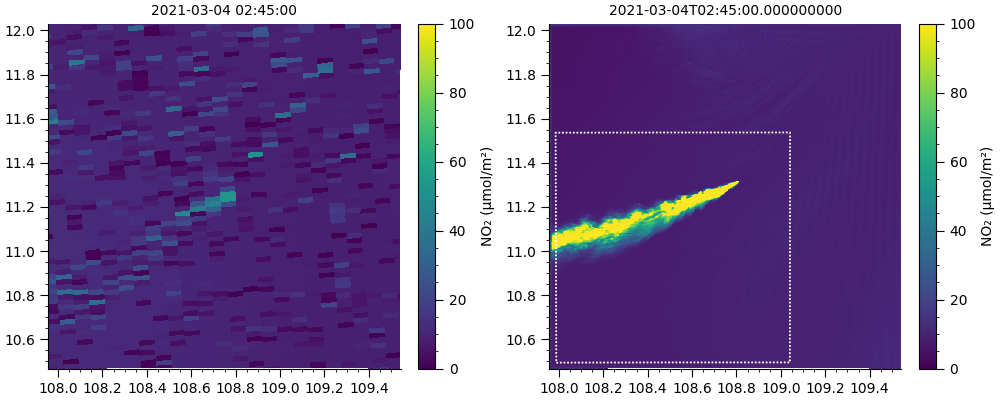

In [51]:
plt.close('all')

request_time = datetime(year=2021, month=3, day=4, hour=2, minute=45)

target_lon = outer_dom.proj.lon
target_lat = outer_dom.proj.lat

no2_gems = parse_gems('ColumnAmountNO2Trop', data_path_raw, request_time, target_lon, target_lat)

no2_out = open_dataset(f'{sim_path}/outer/no2_path.xy.nc', outer_dom, request_time)
no2_inn = open_dataset(f'{sim_path}/inner/no2_path.xy.nc', inner_dom, request_time)

no2_bg = no2_bg_path.sel(time=request_time, method='nearest')

plt.figure(figsize=(10,4), layout='constrained')
plt.subplot(121)
plt.title(request_time)
plt.pcolormesh(target_lon, target_lat, no2_gems/Na*1e10, vmin=0, vmax=100)
plt.colorbar(label='NO₂ (µmol/m²)')

plt.subplot(122)
plt.title(no2_out.time.values)
plt.pcolormesh(outer_dom.proj.lon, outer_dom.proj.lat, (no2_out['no2_path']+no2_bg)*1e6/Mair, vmin=0, vmax=100)
#plt.pcolormesh(inner_dom.proj.lon, inner_dom.proj.lat, (no2_inn['no2_path']+no2_bg_path)*1e6/Mair, vmin=0, vmax=100)
plt.plot(inner_dom.proj.bbox_lon, inner_dom.proj.bbox_lat, 'w:')
plt.colorbar(label='NO₂ (µmol/m²)')